# Perplexity

### Pseudo code:

```
log_perplexity = log(perplexity)
for i=1:N
    for iter=1:200 (assumption)
        for j=1:N  
            P[i][j]= exp(-beta * DD[i][j]
            sum_P += P[i][j]
            H += beta * DD[i][j] * P[i][j]
        H = H/sum_P + log(sum_P)
        Hdiff = H - log_perplexity
        beta_min or beta_max = beta
        beta = (beta_min + beta_max) *= 0.5
        
```

### Cost division
* adds: $N \cdot 200 \cdot (2N + 3)$
* mults: $N \cdot 200  \cdot (3N + 1)$
* divisions: $N \cdot 200 $
* exp and log: $1 + N \cdot 200 \cdot (N+1)$

Total cost: $$W = N \cdot 200 \cdot (6N + 6) + 1 \space \text{flops}$$

### Memory traffic

For every iteration a whole row of the distance matrix DD gets read. 

$$ Q = N \cdot 200 \cdot N \cdot \text{4 Byte} $$


And so the operational intensity is:
$$I \approxeq 1.5  \space \text{flops/byte}$$


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Lets define the flops depending on the input size.

In [2]:
def get_flops(N):
    W =  N * 200 * (6*N + 6) + 1
    return W

Lets import the runtime of each function.

In [3]:
data = pd.read_csv("./bench.csv")
# Extract the input size
N = data["N"].as_matrix()

data

,N,base_version,subexpression and strength reduction,unrolling,blocking
0,8,2.850610e+05,2.475620e+05,2.722420e+05,2.097290e+05
1,16,8.786370e+05,8.262830e+05,8.082900e+05,6.665020e+05
2,32,2.747062e+06,3.214211e+06,2.683256e+06,2.300734e+06
3,64,6.247798e+06,6.228748e+06,6.124484e+06,6.462079e+06
4,128,2.724863e+07,2.403652e+07,2.575540e+07,2.641159e+07
5,256,1.030571e+08,1.053169e+08,1.055955e+08,1.042226e+08
6,512,4.167737e+08,4.087540e+08,4.528725e+08,4.144808e+08
7,1024,2.241671e+09,2.086233e+09,2.113764e+09,2.314990e+09
8,2048,1.382000e+10,1.445349e+10,1.258751e+10,1.418663e+10
9,4096,9.203266e+10,8.820218e+10,9.013775e+10,1.023225e+11


In [4]:
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

In [5]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2)
N_cache2 = np.sqrt(cache_2 / 4 / 2)
N_cache3 = np.sqrt(cache_3 / 4 / 2)
print(f"Cache 1 limit size: {N_cache1}")
print(f"Cache 2 limit size: {N_cache2}")
print(f"Cache 3 limit size: {N_cache3}")

Cache 1 limit size: 64.0
Cache 2 limit size: 181.01933598375618
Cache 3 limit size: 1024.0


## Benchmark 

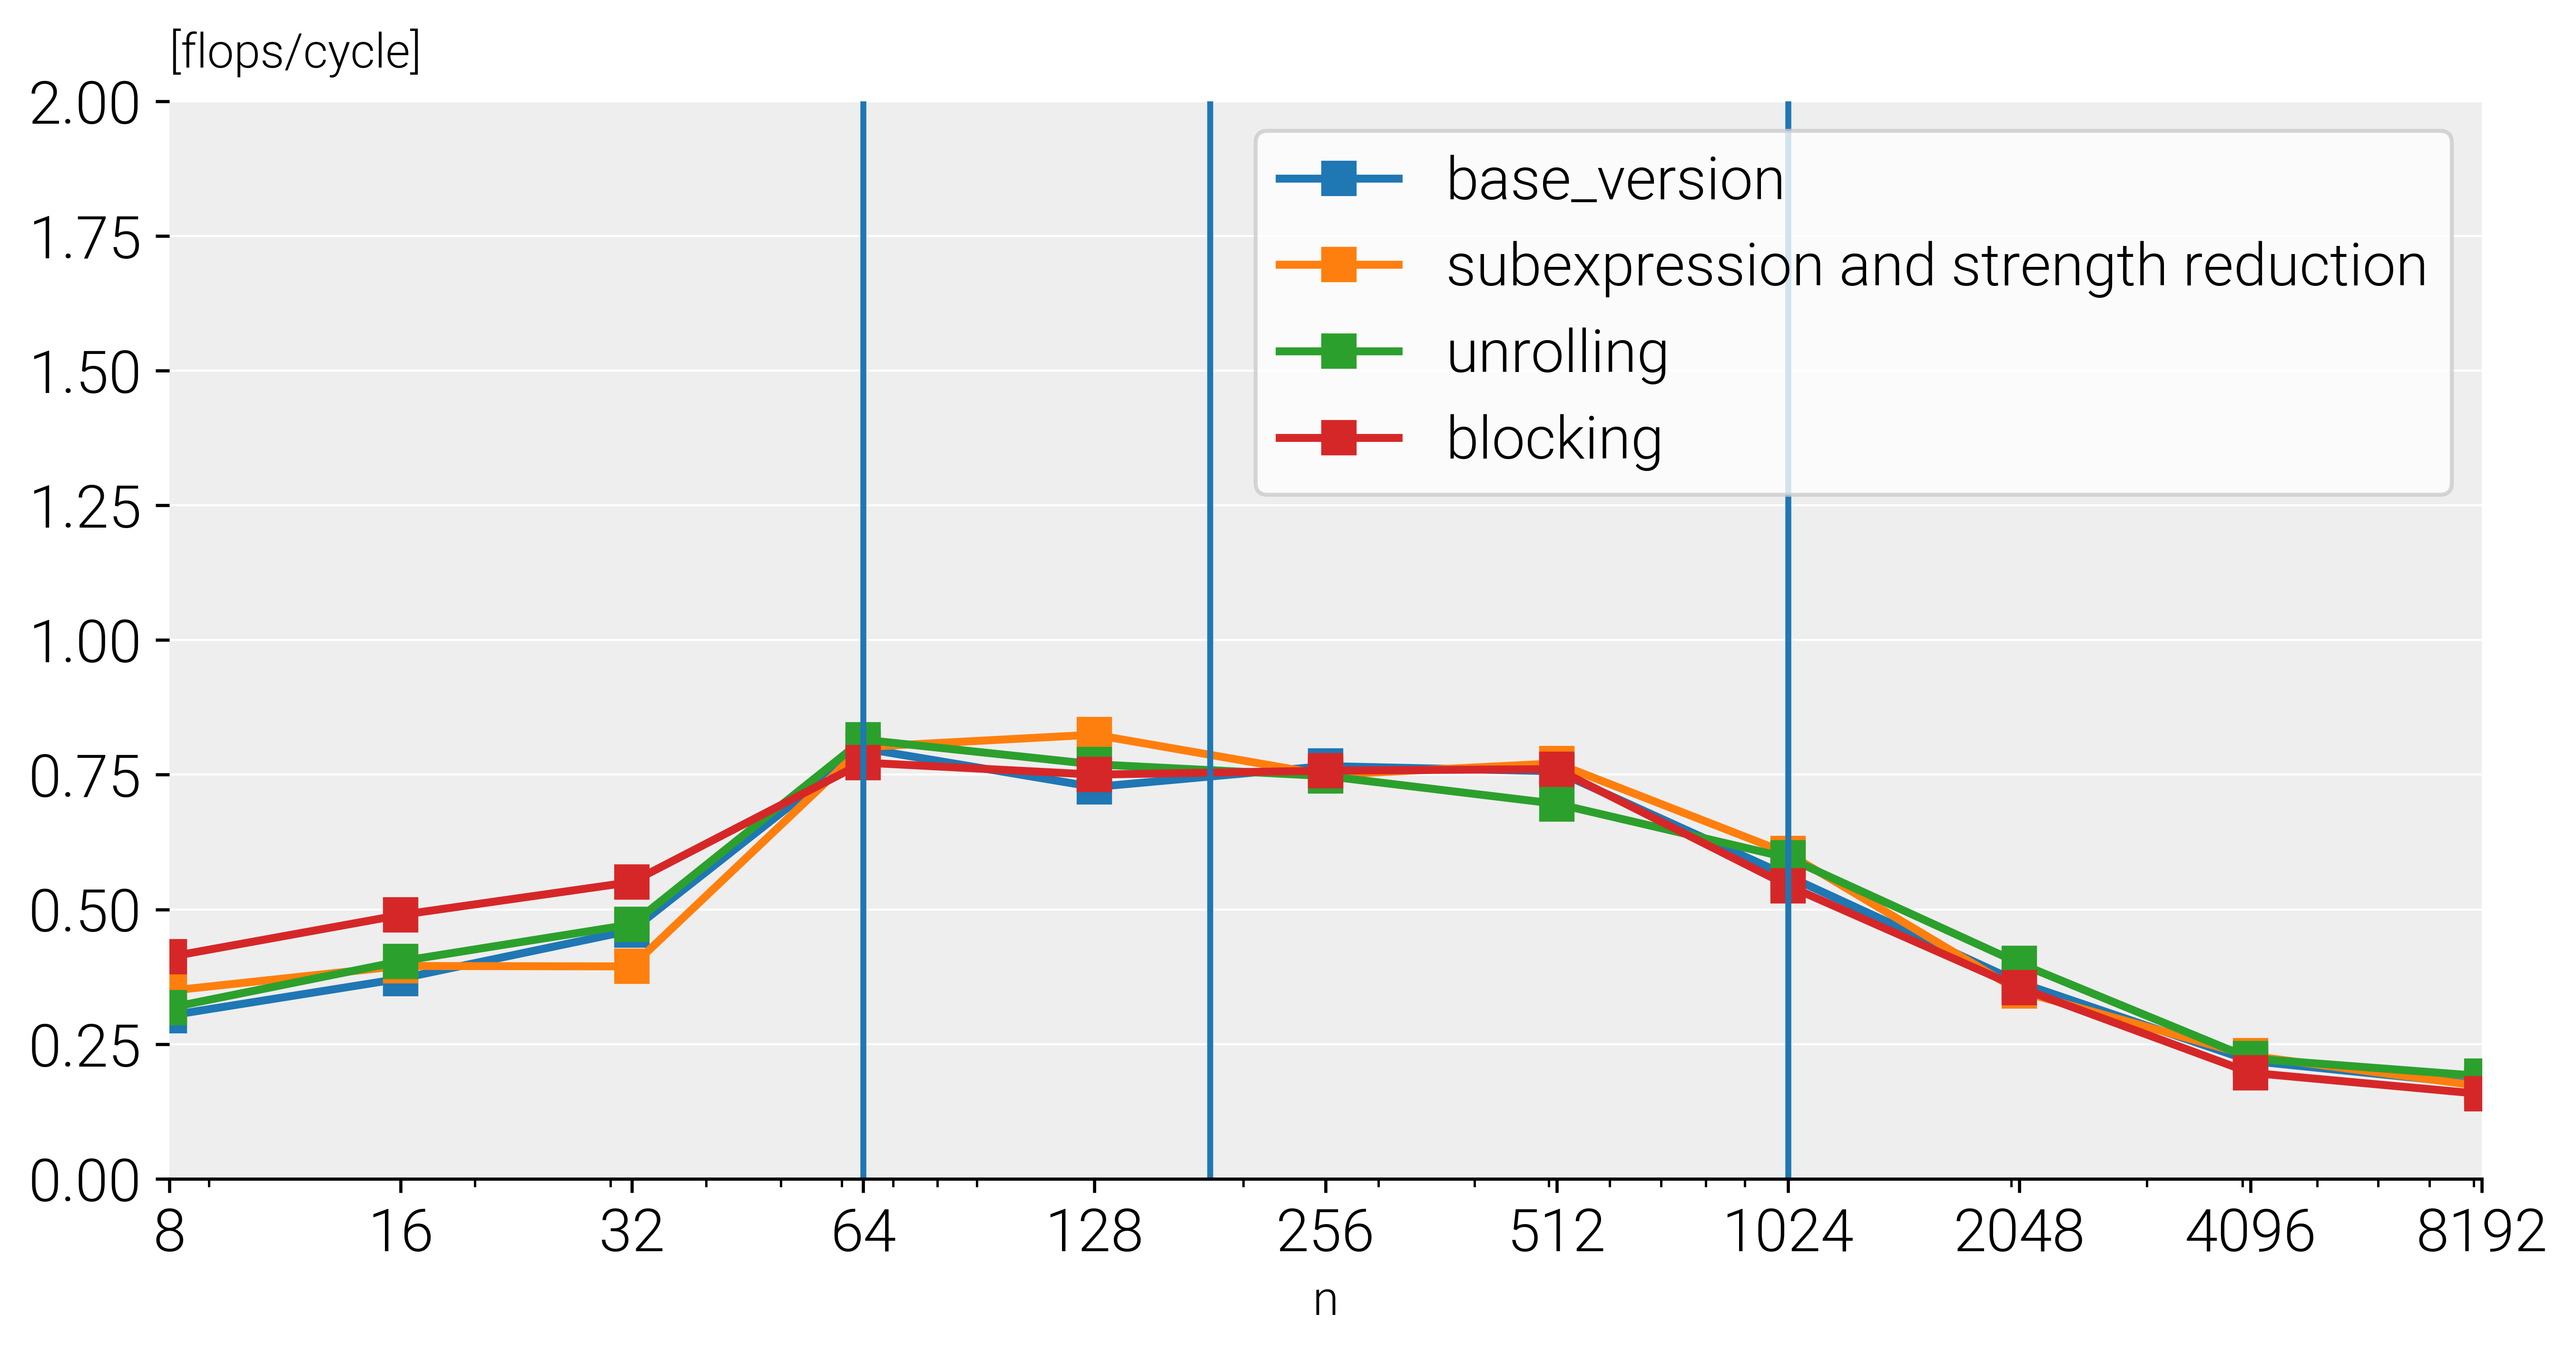

In [6]:
data = pd.read_csv("./bench.csv")

# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = get_flops(N)

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops / cycles
    perf.append(P)

ax = plot(N, perf, labels=func_names, ylim=2)
ax.set_xscale("log")
ax.set_xticks(N)
ax.set_xticklabels(N)
ax.axvline(N_cache1)
ax.axvline(N_cache2)
ax.axvline(N_cache3)
plt.show()

# Complexities

* Memory Bound, only 1.5 Flops/Byte
* For every row and iteration $ sum\_P $ gets updated based on the new $ beta $ value: $ sum\_P = \sum_{j}{e^{-beta \cdot DD[i][j]}} $
* This requires rereading all corresponding values from the distance matrix $ \space DD[i][0:N-1] $ because there is no straightforward relation to update $ sum\_P $ exclusively from the updated beta value